Approximate mass boundaries for Galactic geometry (D_l~4 kpc, D_ls~4 kpc, D_s~8 kpc):
Strong lensing (theta_E > 1 arcsec): M > 9.9e+05 M_sun
Weak lensing (1 mas < theta_E < 1 arcsec): 9.9e-01 < M < 9.9e+05 M_sun
Micro lensing (theta_E < 1 mas): M < 9.9e-01 M_sun

Note: These are for point-like stellar lenses/sources. In practice, microlensing dominates for M <~1 M_sun, with detectable flux variations.

Observed Data Summary: θ_E (arcsec)
                     Event_Name  Lens_Mass_Msun  Distance_kpc  Einstein_Radius_mas  Observed_theta_E_arcsec
OGLE-2011-BLG-0462 (MOA-11-191)           7.100          1.58                 3.00                  0.00300
OGLE-2011-BLG-0462 (reanalysis)           7.880          1.49                 3.20                  0.00320
               OGLE-1999-BUL-32           3.000          5.50                 2.50                  0.00250
              OGLE-2003-BLG-238           0.920          6.00                 0.65                  0.00065
            OGLE-2

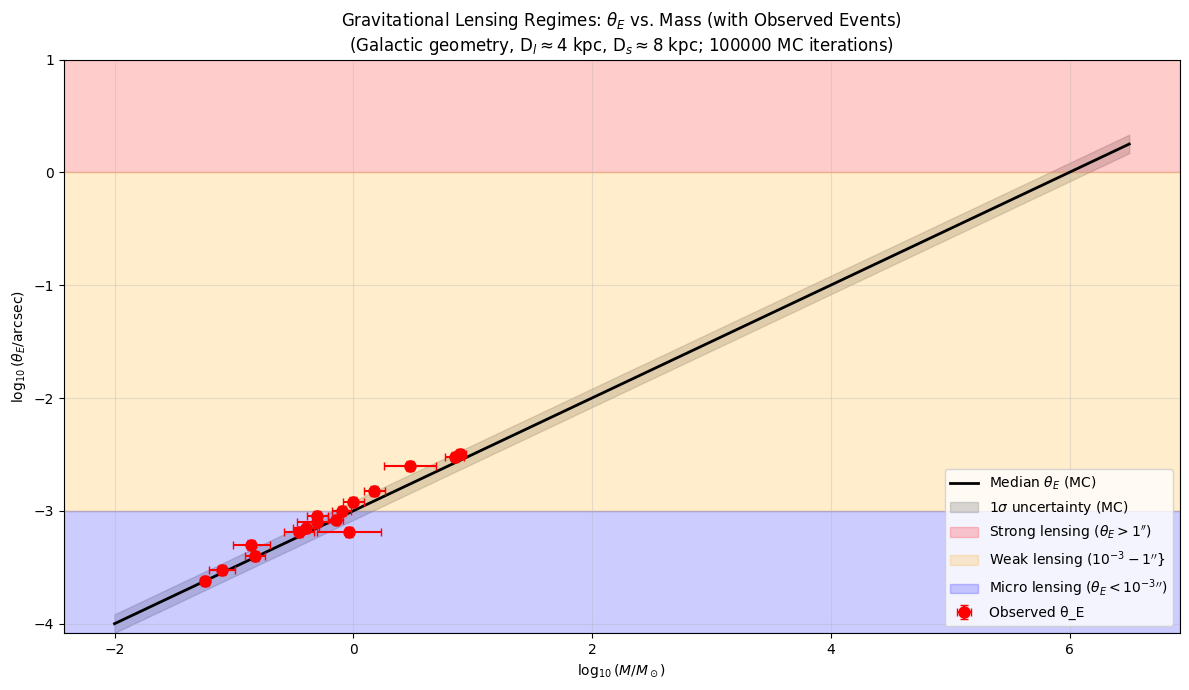

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.constants import G, c
import astropy.units as u
from scipy.stats import norm
from scipy.interpolate import interp1d
import pandas as pd
import warnings
warnings.filterwarnings('ignore')  # Suppress minor warnings for cleaner output

# Define constants in SI units
M_sun = 1.989e30 * u.kg  # Solar mass in kg

def compute_theta_E_gal(M, D_l_kpc, D_s_kpc, D_ls_kpc):
    D_l = D_l_kpc * u.kpc
    D_s = D_s_kpc * u.kpc
    D_ls = D_ls_kpc * u.kpc

    if D_ls <= 0:
        return np.nan

    # Dimensionless quantity for theta_E^2 in radians^2
    rs = (4 * G * M / c**2 * D_ls / (D_l * D_s)).decompose()
    theta_E_rad = np.sqrt(rs.value) * u.rad
    theta_E_arcsec = theta_E_rad.to(u.arcsec).value
    return theta_E_arcsec

# Standard parameters for Galactic microlensing with uncertainties
# Typical distances: lens midway to bulge, D_l ~4 kpc, D_ls ~4 kpc, D_s ~8 kpc
# Uncertainties based on typical variations in surveys (e.g., OGLE)
d_l_mean, d_l_std = 4.0, 1.0  # kpc
d_ls_mean, d_ls_std = 4.0, 1.0  # kpc

# Monte Carlo parameters
n_mc = 100000  # Number of Monte Carlo iterations for error analysis
np.random.seed(42)  # For reproducibility

# Grid of lens masses in solar masses (log-spaced for stellar masses: brown dwarfs to massive stars/supergiants)
# *** THIS IS THE MODIFIED LINE ***
# Extend the upper limit from 2.5 to 6.5 to reach the strong lensing regime
log_m_sun = np.linspace(-2, 6.5, 100)
M_grid = 10**log_m_sun * M_sun  # In kg

# Run Monte Carlo simulations
theta_array = np.zeros((n_mc, len(M_grid)))
valid_samples = 0
for i in range(n_mc):
    # Sample distances
    d_l_sample = norm.rvs(d_l_mean, d_l_std)
    d_ls_sample = norm.rvs(d_ls_mean, d_ls_std)
    d_s_sample = d_l_sample + d_ls_sample

    # Skip invalid (negative distances, rare)
    if d_l_sample <= 0 or d_ls_sample <= 0 or d_s_sample <= 0:
        continue

    valid_samples += 1

    # Compute theta_E for each M
    for j, M in enumerate(M_grid):
        theta_array[i, j] = compute_theta_E_gal(M, d_l_sample, d_s_sample, d_ls_sample)

# Normalize for nans/invalids (fill remaining with median for plotting stability, but stats handle nan)
if valid_samples < n_mc:
    print(f"Warning: {n_mc - valid_samples} invalid samples skipped; using {valid_samples} valid MC iterations.")
# Replace 0s (from invalid samples) with NaN to exclude them from stats
theta_array[theta_array == 0] = np.nan

# Compute statistics: median and 16th/84th percentiles (1-sigma equivalent for Gaussian)
median_theta = np.nanmedian(theta_array, axis=0)
p16_theta = np.nanpercentile(theta_array, 16, axis=0)
p84_theta = np.nanpercentile(theta_array, 84, axis=0)

# Compute approximate mass boundaries from median (where theta_E = boundary values)
# Boundaries: Strong >1 arcsec, Weak 0.001-1 arcsec (1 mas to 1"), Micro <0.001 arcsec
# Note: For stellar masses in Galactic setting, strong lensing requires very massive stars (~1000+ M_sun, rare)
theta_strong = 1.0  # arcsec
theta_weak_low = 0.001  # 1 mas
# Since theta_E ∝ sqrt(M), M ∝ theta_E^2
# Find M where median_theta == boundary (interpolate)
log_m_interp = interp1d(np.log10(median_theta), log_m_sun, kind='linear', bounds_error=False, fill_value='extrapolate')
m_strong = 10**log_m_interp(np.log10(theta_strong))
m_weak_low = 10**log_m_interp(np.log10(theta_weak_low))

print(f"Approximate mass boundaries for Galactic geometry (D_l~4 kpc, D_ls~4 kpc, D_s~8 kpc):")
print(f"Strong lensing (theta_E > 1 arcsec): M > {m_strong:.1e} M_sun")
print(f"Weak lensing (1 mas < theta_E < 1 arcsec): {m_weak_low:.1e} < M < {m_strong:.1e} M_sun")
print(f"Micro lensing (theta_E < 1 mas): M < {m_weak_low:.1e} M_sun")
print("\nNote: These are for point-like stellar lenses/sources. In practice, microlensing dominates for M <~1 M_sun, with detectable flux variations.")

# Verification with observed data
# Load the observed data
try:
    df_obs = pd.read_csv('observed_microlensing_masses.csv')

    # Observed theta_E in arcsec
    df_obs['Observed_theta_E_arcsec'] = df_obs['Einstein_Radius_mas'] / 1000.0

    # Filter valid entries (non-NaN observed theta_E)
    valid_mask = df_obs['Observed_theta_E_arcsec'].notna()
    df_valid = df_obs[valid_mask].copy()

    # Print summary table (observed only)
    print("\nObserved Data Summary: θ_E (arcsec)")
    summary_cols = ['Event_Name', 'Lens_Mass_Msun', 'Distance_kpc', 'Einstein_Radius_mas', 'Observed_theta_E_arcsec']
    print(df_valid[summary_cols].round(6).to_string(index=False))

    # Flag for plotting observed data
    plot_observed_data = True

except FileNotFoundError:
    print("\nWarning: 'observed_microlensing_masses.csv' not found. Skipping observed data steps.")
    plot_observed_data = False
except KeyError as e:
    print(f"\nWarning: CSV file missing expected column: {e}. Skipping observed data steps.")
    plot_observed_data = False


# Plotting (main MC plot with observed points overlaid)
fig, ax = plt.subplots(figsize=(12, 7))

# Plot median line
ax.plot(log_m_sun, np.log10(median_theta), 'k-', linewidth=2, label='Median $\\theta_E$ (MC)')

# Plot error band (1-sigma)
ax.fill_between(log_m_sun, np.log10(p16_theta), np.log10(p84_theta), alpha=0.3, color='gray', label='1$\\sigma$ uncertainty (MC)')

# Shade regions based on theta_E (horizontal bands in log-log plot)
y_max = np.log10(10)  # ~1 arcsec scale
y_min = np.log10(np.nanmin(p16_theta)) # Use data minimum for lower bound
if np.isinf(y_min): # Handle case where all values might be 0/nan
    y_min = -6

ax.axhspan(np.log10(theta_strong), y_max, alpha=0.2, color='red', label='Strong lensing ($\\theta_E > 1^{\\prime\\prime}$)')
ax.axhspan(np.log10(theta_weak_low), np.log10(theta_strong), alpha=0.2, color='orange', label='Weak lensing ($10^{-3}-1^{\\prime\\prime}$}')

# *** THIS IS THE FIXED LINE ***
# Grouped {10^{-3}} to fix double superscript error
ax.axhspan(y_min, np.log10(theta_weak_low), alpha=0.2, color='blue', label='Micro lensing ($\\theta_E < {10^{-3}}^{\\prime\\prime}$)')

# Overlay observed data if loaded successfully
if plot_observed_data:
    # Error bars: Approximate symmetric log errors
    # For M: delta_logM ≈ (delta_M / M) / ln(10)
    m_err = (df_valid['Mass_Error_Upper_Msun'].fillna(df_valid['Mass_Error_Lower_Msun']) +
             df_valid['Mass_Error_Lower_Msun'].fillna(df_valid['Mass_Error_Upper_Msun'])) / 2 / df_valid['Lens_Mass_Msun']
    m_err_log = m_err / np.log(10)  # For xerr in log space

    # For θ_E observed: Assume 10% relative error (typical for microlensing)
    theta_obs_rel_err = 0.1
    theta_obs_err_log = theta_obs_rel_err / np.log(10)

    # Plot observed
    ax.errorbar(np.log10(df_valid['Lens_Mass_Msun']), np.log10(df_valid['Observed_theta_E_arcsec']),
                xerr=m_err_log, yerr=theta_obs_err_log,
                fmt='ro', markersize=8, capsize=3, label='Observed θ_E', zorder=5)

    ax.set_title('Gravitational Lensing Regimes: $\\theta_E$ vs. Mass (with Observed Events)\n(Galactic geometry, D$_l \\approx 4$ kpc, D$_s \\approx 8$ kpc; 100000 MC iterations)')
else:
    ax.set_title('Gravitational Lensing Regimes: $\\theta_E$ vs. Mass\n(Galactic geometry, D$_l \\approx 4$ kpc, D$_s \\approx 8$ kpc; 100000 MC iterations)')


# Labels and formatting
ax.set_xlabel('$\\log_{10} (M / M_\\odot)$')
ax.set_ylabel('$\\log_{10} (\\theta_E / \\mathrm{arcsec})$')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_ylim(y_min, y_max) # Set y-limits to match shaded regions
plt.tight_layout()
plt.show()